### SECTION - A

In [1]:
import random
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

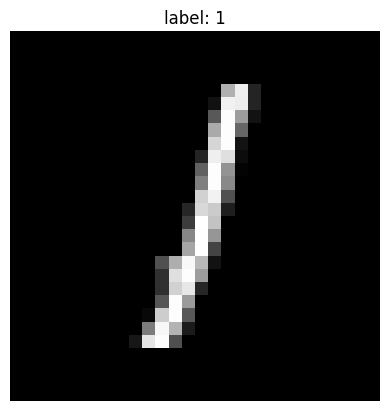

In [3]:
# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

rn = random.randint(0, len(x_train))

plt.imshow(x_train[rn], cmap='gray')
plt.title(f'label: {y_train[rn]}')
plt.axis('off')
plt.show()

In [4]:
# Create a dataset with rotated images
def rotate_images(images, labels):
    rotated_images = []
    rotated_labels = []
    
    for image, label in zip(images, labels):
        # Original image (0 degrees)
        rotated_images.append(image)
        rotated_labels.append(label)
        
        # Rotate 90 degrees
        rot_90 = tf.image.rot90(image)
        rotated_images.append(rot_90)
        rotated_labels.append(label)
        
        # Rotate 180 degrees
        rot_180 = tf.image.rot90(rot_90)
        rotated_images.append(rot_180)
        rotated_labels.append(label)
        
        # Rotate 270 degrees
        rot_270 = tf.image.rot90(rot_180)
        rotated_images.append(rot_270)
        rotated_labels.append(label)
    
    return np.array(rotated_images), np.array(rotated_labels)

In [5]:
# Create rotated datasets
x_train_rot, y_train_rot = rotate_images(x_train[:10000], y_train[:10000])
x_test_rot, y_test_rot = rotate_images(x_test[:1000], y_test[:1000])

print('X-TRAIN: ')
print(x_train_rot.shape, y_train_rot.shape)

print('X-TEST: ')
print(x_test_rot.shape, y_test_rot.shape)

print('--' * 10)

X-TRAIN: 
(40000, 28, 28, 1) (40000,)
X-TEST: 
(4000, 28, 28, 1) (4000,)
--------------------


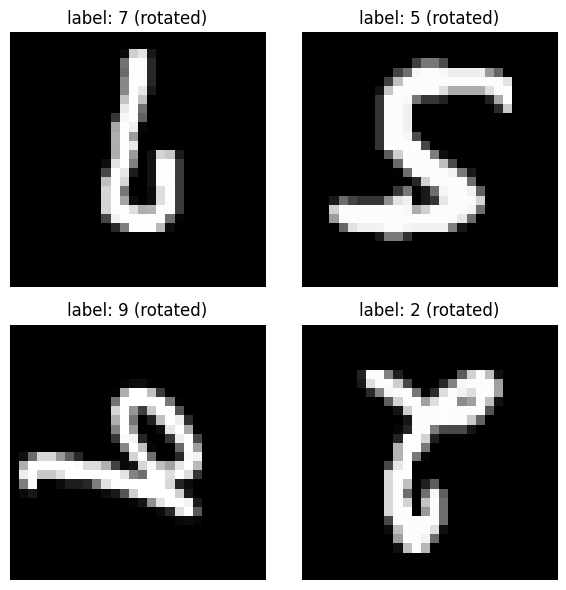

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for ax in axes.flat:
    rn = random.randint(0, len(x_train_rot) - 1)
    ax.imshow(x_train_rot[rn], cmap='gray')
    ax.set_title(f'label: {y_train_rot[rn]} (rotated)')
    ax.axis('off')

plt.tight_layout()
plt.savefig('saves/plots/rot_4_tile.png')
plt.show()

This is Rotation Equivariance - meaning f(TX) = Tf(X) - the order of function and transformation doesn't matter -- application of Conv layer on rotated image == Rotated Conv layer response map && CNNs are Translation Invariant

In [8]:
# Custom rotation-equivariant layer
class RotationEquivariantLayer(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(RotationEquivariantLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        
        # Create a single convolutional layer that will be shared
        self.conv = layers.Conv2D(filters, kernel_size, padding='same')
        
    def call(self, inputs):
        # Original orientation (0 degrees)
        x_0 = self.conv(inputs)
        
        # Rotate input 90 degrees, apply conv, then rotate output back
        x_90 = tf.image.rot90(inputs, k=1)
        x_90 = self.conv(x_90)
        x_90 = tf.image.rot90(x_90, k=3)  # Rotate back (270 degrees)
        
        # Rotate input 180 degrees, apply conv, then rotate output back
        x_180 = tf.image.rot90(inputs, k=2)
        x_180 = self.conv(x_180)
        x_180 = tf.image.rot90(x_180, k=2)  # Rotate back (180 degrees)
        
        # Rotate input 270 degrees, apply conv, then rotate output back
        x_270 = tf.image.rot90(inputs, k=3)
        x_270 = self.conv(x_270)
        x_270 = tf.image.rot90(x_270, k=1)  # Rotate back (90 degrees)
        
        # Average the outputs (this gives rotation equivariance)
        return (x_0 + x_90 + x_180 + x_270) / 4
    
    def get_config(self):
        config = super(RotationEquivariantLayer, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size
        })
        return config

In [47]:
# Verify the layer's equivariance property
def test_equivariance():
    # Create a test image
    test_image = x_test[0:1]
    
    # Create rotated versions
    rot_90 = tf.image.rot90(test_image)
    rot_180 = tf.image.rot90(rot_90)
    rot_270 = tf.image.rot90(rot_180)
    
    # Create layer instance
    layer = RotationEquivariantLayer(16, (3, 3))
    
    # Apply layer to each rotation
    output_0 = layer(test_image)
    output_90 = layer(rot_90)
    output_180 = layer(rot_180)
    output_270 = layer(rot_270)
    
    # Rotate outputs to compare
    rotated_output_90 = tf.image.rot90(output_90, k=3)
    rotated_output_180 = tf.image.rot90(output_180, k=2)
    rotated_output_270 = tf.image.rot90(output_270, k=1)
    
    fig, axs = plt.subplots(4, 2, figsize=(3, 8))
    
    # Row 1
    axs[0, 0].imshow(test_image[0, :, :, 0], cmap='gray')
    axs[0, 0].set_title('output_0', fontsize = 8)
    axs[0, 0].axis('off')

    axs[0, 1].imshow(output_0[0, :, :, 0], cmap='gray')
    axs[0, 1].set_title('rotated_output_0', fontsize = 8)
    axs[0, 1].axis('off')

    # Row 2
    axs[1, 0].imshow(rot_90[0, :, :, 0], cmap='gray')
    axs[1, 0].set_title('output_0', fontsize = 8)
    axs[1, 0].axis('off')

    axs[1, 1].imshow(output_90[0, :, :, 0], cmap='gray')
    axs[1, 1].set_title('rotated_output_180', fontsize = 8)
    axs[1, 1].axis('off')

    # Row 3
    axs[2, 0].imshow(rot_180[0, :, :, 0], cmap='gray')
    axs[2, 0].set_title('output_0', fontsize = 8)
    axs[2, 0].axis('off')

    axs[2, 1].imshow(output_180[0, :, :, 0], cmap='gray')
    axs[2, 1].set_title('rotated_output_270', fontsize = 8)
    axs[2, 1].axis('off')

    # Row 3
    axs[3, 0].imshow(rot_270[0, :, :, 0], cmap='gray')
    axs[3, 0].set_title('output_0', fontsize = 8)
    axs[3, 0].axis('off')

    axs[3, 1].imshow(output_270[0, :, :, 0], cmap='gray')
    axs[3, 1].set_title('rotated_output_370', fontsize = 8)
    axs[3, 1].axis('off')

    plt.savefig('saves/plots/rot_comp_tile.png')
    plt.show()

    # Check if outputs are similar (should be nearly identical for perfect equivariance)
    diff_90 = tf.reduce_mean(tf.abs(output_0 - rotated_output_90))
    diff_180 = tf.reduce_mean(tf.abs(output_0 - rotated_output_180))
    diff_270 = tf.reduce_mean(tf.abs(output_0 - rotated_output_270))
    
    print(f"Mean absolute difference (0° vs 90°): {diff_90.numpy()}")
    print(f"Mean absolute difference (0° vs 180°): {diff_180.numpy()}")
    print(f"Mean absolute difference (0° vs 270°): {diff_270.numpy()}")
    
    return diff_90.numpy(), diff_180.numpy(), diff_270.numpy()


### FCNN

In [10]:
def build_dnn(input_size, hidden_size=64, num_classes=10):
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_size),  # Corrected the input layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(hidden_size * 2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.BatchNormalization(),  # Fixed the typo
        tf.keras.layers.Dense(num_classes, activation='linear')  # No need for activation if using SparseCategoricalCrossentropy with logits
    ])

    model.compile(optimizer='adam',  # Corrected the keyword argument
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

# Assuming x_train is your training data
dnn_model = build_dnn(input_size=x_train.shape[1:])
dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,490 (267.54 KB)

 Trainable params: 67,978 (265.54 KB)

 Non-trainable params: 512 (2.00 KB)

### Regular CNN

In [11]:
# Create regular CNN model
class RegularModel(tf.keras.models.Model):
    def __init__(self, num_class=10, input_shape=(28, 28, 1), kernel_size=(3, 3), output_size=[32, 64, 128]):
        super(RegularModel, self).__init__()
        
        self.conv1 = layers.Conv2D(output_size[0], kernel_size=kernel_size, activation=None, input_shape=input_shape)
        self.conv2 = layers.Conv2D(output_size[1], kernel_size=kernel_size, activation=None)
        self.conv3 = layers.Conv2D(output_size[-1], kernel_size=kernel_size, activation=None)
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(num_class, activation='softmax')
    
    def call(self, x, is_visual=False):
        x_conv1 = self.conv1(x)
        x = layers.Activation('relu')(x_conv1)
        x = layers.MaxPooling2D((2, 2))(x)
        
        x_conv2 = self.conv2(x)
        x = layers.Activation('relu')(x_conv2)
        
        x_conv3 = self.conv3(x)
        x = layers.Activation('relu')(x_conv3)
        x = layers.MaxPooling2D((2, 2))(x)
        
        x = layers.Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        
        if is_visual:
            return x_conv1, x_conv2, x_conv3
        
        return x
    
    def visual(self, x_conv):
        '''
        Plots the Evolution of Response Maps (by Convolution Layers)
        '''
        x_conv1, x_conv2, x_conv3 = x_conv
        
        fig, axs = plt.subplots(1, 3, figsize=(6, 6))
        
        axs[0].imshow(x_conv1[0, :, :, 0], cmap='gray')
        axs[1].imshow(x_conv2[0, :, :, 0], cmap='gray')
        axs[2].imshow(x_conv3[0, :, :, 0], cmap='gray')
        
        axs[0].set_title('Conv-Layer-1')
        axs[1].set_title('Conv-Layer-2')
        axs[2].set_title('Conv-Layer-3')

        plt.tight_layout(pad = 1)
        plt.show()

regular_model = RegularModel()
regular_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(' --- MODEL SUMMARY --- ')
regular_model.summary()

 --- MODEL SUMMARY --- 


c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "regular_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Equivariant CNN

In [12]:

# Create equivariant CNN model
class EquivariantModel(keras.models.Model):
    def __init__(self, num_class = 10, input_shape = (28, 28, 1), kernel_size = (3, 3), output_size = [32, 64, 128]):
        super(EquivariantModel, self).__init__()
        
        self.eq_layer_1 = RotationEquivariantLayer(filters=output_size[0], kernel_size=kernel_size, input_shape=input_shape)
        self.eq_layer_2 = RotationEquivariantLayer(filters=output_size[1], kernel_size=kernel_size)
        self.eq_layer_3 = RotationEquivariantLayer(filters=output_size[-1], kernel_size=kernel_size)
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(num_class, activation='softmax')

    
    def call(self, x, is_visual=False):
        
        x_eq_1 = self.eq_layer_1(x)
        x = layers.Activation('relu')(x_eq_1) ## NO params here
        x = layers.MaxPooling2D((2, 2))(x)

        x_eq_2 = self.eq_layer_2(x)
        x = layers.Activation('relu')(x_eq_2) ## NO params here
        
        x_eq_3 = self.eq_layer_3(x)
        x = layers.Activation('relu')(x_eq_3) ## NO params here
        x = layers.MaxPooling2D((2, 2))(x)
        
        x = layers.Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)

        if is_visual:
             return x_eq_1, x_eq_2, x_eq_3

        return x
    
    def visual(self, x_eq):
        '''
        Plots the Evolution of Response Maps (by Equivariance Layers)
        '''
        x_eq_1, x_eq_2, x_eq_3 = x_eq

        fig, axs = plt.subplots(1, 3, figsize=(6, 6))
        
        axs[0].imshow(x_eq_1[0, :, :, 0], cmap='gray')
        axs[1].imshow(x_eq_2[0, :, :, 0], cmap='gray')
        axs[2].imshow(x_eq_3[0, :, :, 0], cmap='gray')

        axs[0].set_title('Equivariance-Layer-1')
        axs[1].set_title('Equivariance-Layer-2')
        axs[2].set_title('Equivariance-Layer-3')

        plt.tight_layout(pad = 2)
        plt.show()

class ResponseMapVisualizationCallback(keras.callbacks.Callback):
    def __init__(self, sample_input, frequency=1):
        super().__init__()
        self.sample_input = sample_input
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:  # Visualize every 'frequency' epochs
            # Create submodel to get intermediate outputs
            eq_layer_1, eq_layer_2, eq_layer_3 = self.model(self.sample_input, is_visual = True)
            self.model.visual([eq_layer_1, eq_layer_2, eq_layer_3])

eq_model = EquivariantModel()
eq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(' --- MODEL SUMMARY --- ')
eq_model.summary()

 --- MODEL SUMMARY --- 


C:\Users\Alik\AppData\Local\Temp\ipykernel_14156\2926765303.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RotationEquivariantLayer, self).__init__(**kwargs)


Model: "equivariant_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rotation_equivariant_layer      │ ?                      │   0 (unbuilt) │
│ (RotationEquivariantLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rotation_equivariant_layer_1    │ ?                      │   0 (unbuilt) │
│ (RotationEquivariantLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rotation_equivariant_layer_2    │ ?                      │   0 (unbuilt) │
│ (RotationEquivariantLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Direct - Conv / Equi - Conv Comparison


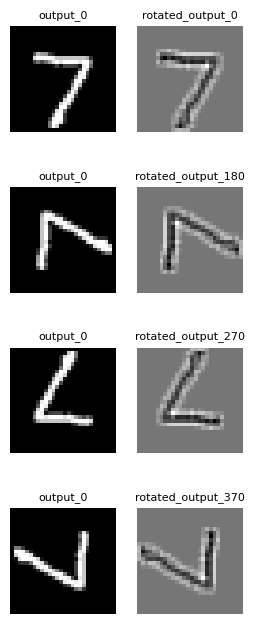

Mean absolute difference (0° vs 90°): 9.75107661282948e-10
Mean absolute difference (0° vs 180°): 1.0502485547903007e-09
Mean absolute difference (0° vs 270°): 9.748466478498585e-10



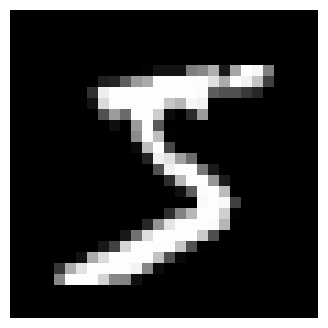

In [48]:
# Test equivariance property
print('Direct - Conv / Equi - Conv Comparison')
diffs = test_equivariance()
print()

sample_input = x_train_rot[:1].reshape(1, 28, 28, 1)

plt.figure(figsize=(4, 4))
plt.imshow(sample_input[0], cmap='gray')
plt.axis('off')
plt.show()

viz_callback = ResponseMapVisualizationCallback(sample_input=sample_input, frequency=10)

### Training 

In [27]:
# # Train and evaluate regular model
dnn_history = dnn_model.fit(
    x_train_rot, y_train_rot,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    steps_per_epoch=128
)

dnn_score = dnn_model.evaluate(x_test_rot, y_test_rot)
print(f"Regular CNN - Test Loss: {dnn_score[0]}, Test Accuracy: {dnn_score[1]}")

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4215 - loss: 1.7912 - val_accuracy: 0.5978 - val_loss: 1.4580
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7245 - loss: 0.8638 - val_accuracy: 0.7510 - val_loss: 0.8576
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7832 - loss: 0.6985 - val_accuracy: 0.8109 - val_loss: 0.6229
Epoch 4/20
110/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8335 - loss: 0.5464

c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8340 - loss: 0.5448 - val_accuracy: 0.8332 - val_loss: 0.5517
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8718 - loss: 0.4440 - val_accuracy: 0.8490 - val_loss: 0.5028
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8842 - loss: 0.4041 - val_accuracy: 0.8587 - val_loss: 0.4751
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8721 - loss: 0.4203 - val_accuracy: 0.8534 - val_loss: 0.4714
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8797 - loss: 0.4031 - val_accuracy: 0.8695 - val_loss: 0.4220
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8990 - loss: 0.3117 - val_accuracy: 0.8798 - val_loss: 0.4025
Epoch 10/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9141 - loss: 0.2859 - val_accuracy: 0.8773 - val_loss: 0.3947
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9065 - loss: 0.3032 - val_accuracy: 0.8870 - va

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.4560 - loss: 1.5723 - val_accuracy: 0.7843 - val_loss: 0.7177
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8481 - loss: 0.5002 - val_accuracy: 0.8739 - val_loss: 0.4005
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8956 - loss: 0.3392 - val_accuracy: 0.8978 - val_loss: 0.3244
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9184 - loss: 0.2636 - val_accuracy: 0.9125 - val_loss: 0.2853
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9419 - loss: 0.1954 - val_accuracy: 0.9187 - val_loss: 0.2712
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9486 - loss: 0.1790 - val_accuracy: 0.9210 - val_loss: 0.2514
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9434 - loss: 0.1740 - val_accuracy: 0.9352 - val_loss: 0.2120
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9498 - loss: 0.1585 - val_accu

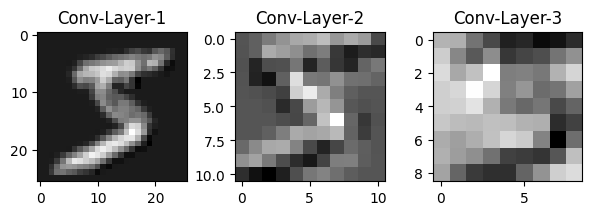

128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9625 - loss: 0.1112 - val_accuracy: 0.9440 - val_loss: 0.1789
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9692 - loss: 0.1026 - val_accuracy: 0.9416 - val_loss: 0.1924
Epoch 12/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9690 - loss: 0.1070 - val_accuracy: 0.9504 - val_loss: 0.1702
Epoch 13/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9823 - loss: 0.0581 - val_accuracy: 0.9481 - val_loss: 0.1790
Epoch 14/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9780 - loss: 0.0645 - val_accuracy: 0.9542 - val_loss: 0.1506
Epoch 15/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9719 - loss: 0.0829 - val_accuracy: 0.9454 - val_loss: 0.1791
Epoch 16/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9719 - loss: 0.0866 - val_accuracy: 0.9514 - val_loss: 0.1573
Epoch 17/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9859 - loss: 0.0404 - val_accuracy

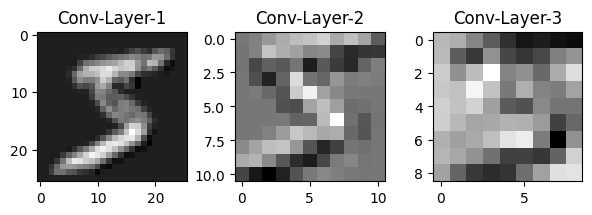

128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9810 - loss: 0.0547 - val_accuracy: 0.9538 - val_loss: 0.1667
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9618 - loss: 0.1463
Regular CNN - Test Loss: 0.16424569487571716, Test Accuracy: 0.9564999938011169


In [29]:
# # Train and evaluate regular model
regular_history = regular_model.fit(
    x_train_rot, y_train_rot,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[viz_callback],
    verbose=1,
    steps_per_epoch=128
)

regular_score = regular_model.evaluate(x_test_rot, y_test_rot)
print(f"Regular CNN - Test Loss: {regular_score[0]}, Test Accuracy: {regular_score[1]}")

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 48s 265ms/step - accuracy: 0.2754 - loss: 1.9675 - val_accuracy: 0.4971 - val_loss: 1.4136
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 249ms/step - accuracy: 0.5709 - loss: 1.2248 - val_accuracy: 0.6200 - val_loss: 1.1192
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.6815 - loss: 0.9650 - val_accuracy: 0.7030 - val_loss: 0.9236
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step - accuracy: 0.7388 - loss: 0.7888 - val_accuracy: 0.7630 - val_loss: 0.7469
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/step - accuracy: 0.7886 - loss: 0.6395 - val_accuracy: 0.7788 - val_loss: 0.6891
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 258ms/step - accuracy: 0.8033 - loss: 0.6292 - val_accuracy: 0.8179 - val_loss: 0.5877
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 257ms/step - accuracy: 0.8254 - loss: 0.5628 - val_accuracy: 0.8275 - val_loss: 0.5662
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 241ms/step - accuracy: 0.8538 - loss: 0

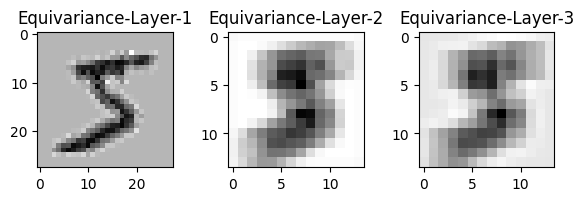

128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 263ms/step - accuracy: 0.8779 - loss: 0.4046 - val_accuracy: 0.8339 - val_loss: 0.5387
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 256ms/step - accuracy: 0.8842 - loss: 0.3857 - val_accuracy: 0.8689 - val_loss: 0.4512
Epoch 12/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step - accuracy: 0.8755 - loss: 0.3896 - val_accuracy: 0.8691 - val_loss: 0.4345
Epoch 13/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 242ms/step - accuracy: 0.9073 - loss: 0.3132 - val_accuracy: 0.8520 - val_loss: 0.4748
Epoch 14/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 234ms/step - accuracy: 0.9018 - loss: 0.3042 - val_accuracy: 0.8689 - val_loss: 0.4442
Epoch 15/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 45s 350ms/step - accuracy: 0.9018 - loss: 0.3277 - val_accuracy: 0.8777 - val_loss: 0.3999
Epoch 16/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 38s 298ms/step - accuracy: 0.9053 - loss: 0.3020 - val_accuracy: 0.8769 - val_loss: 0.4104
Epoch 17/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 39s 306ms/step - accuracy: 0.9224 - loss: 0.245

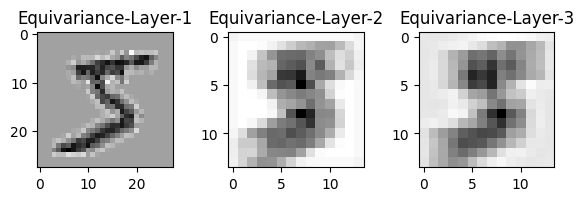

128/128 ━━━━━━━━━━━━━━━━━━━━ 37s 293ms/step - accuracy: 0.9214 - loss: 0.2341 - val_accuracy: 0.8967 - val_loss: 0.3513
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9058 - loss: 0.2846
Equivariant CNN - Test Loss: 0.2935231626033783, Test Accuracy: 0.9024999737739563


In [30]:
# Train and evaluate equivariant model
equivariant_history = eq_model.fit(
    x_train_rot, y_train_rot,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[viz_callback],
    verbose=1,
    steps_per_epoch=128
)

equivariant_score = eq_model.evaluate(x_test_rot, y_test_rot)
print(f"Equivariant CNN - Test Loss: {equivariant_score[0]}, Test Accuracy: {equivariant_score[1]}")


### Training Metrics

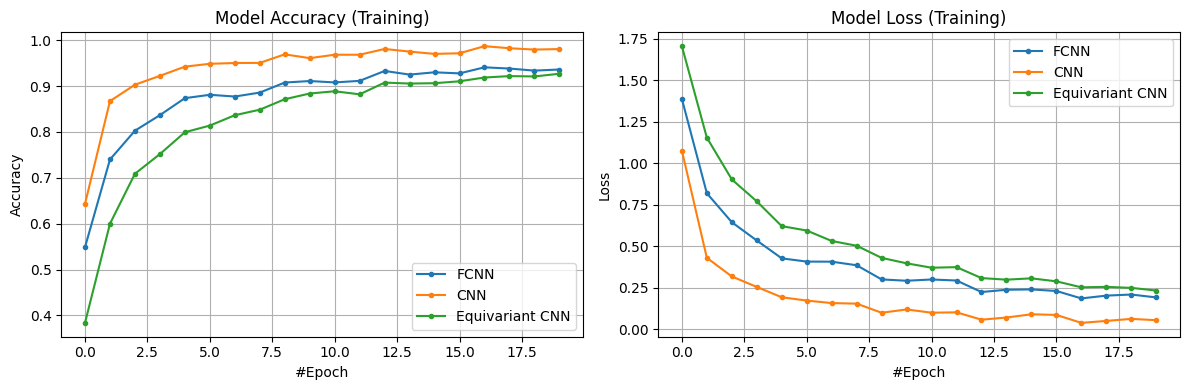

In [33]:
# Plot training histories
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dnn_history.history['accuracy'], label='FCNN', marker = '.')
plt.plot(regular_history.history['accuracy'], label='CNN', marker = '.')
plt.plot(equivariant_history.history['accuracy'], label='Equivariant CNN', marker = '.')
plt.title('Model Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('#Epoch')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dnn_history.history['loss'], label='FCNN', marker = '.')
plt.plot(regular_history.history['loss'], label='CNN', marker = '.')
plt.plot(equivariant_history.history['loss'], label='Equivariant CNN', marker = '.')
plt.title('Model Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('#Epoch')
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('train_acc_loss_comp.png')
plt.show()

### Validation Metrics

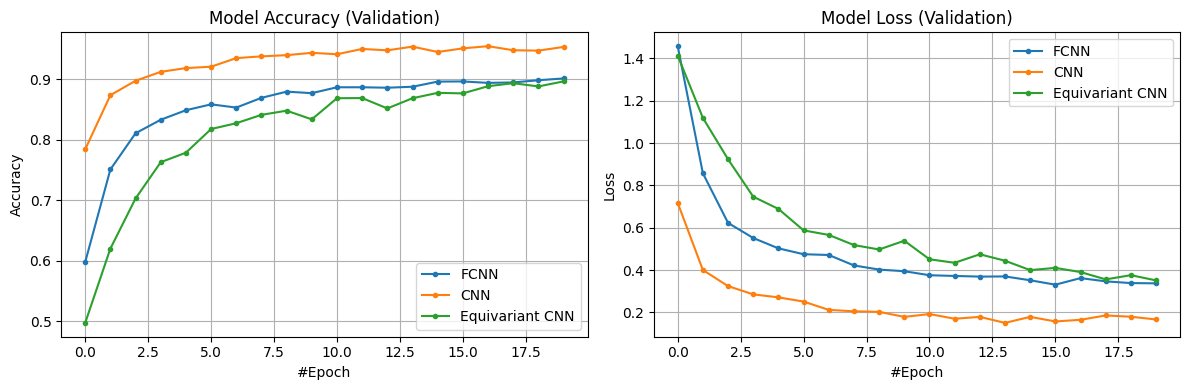

In [34]:
# Plot training histories
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dnn_history.history['val_accuracy'], label='FCNN', marker = '.')
plt.plot(regular_history.history['val_accuracy'], label='CNN', marker = '.')
plt.plot(equivariant_history.history['val_accuracy'], label='Equivariant CNN', marker = '.')
plt.title('Model Accuracy (Validation)')
plt.ylabel('Accuracy')
plt.xlabel('#Epoch')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dnn_history.history['val_loss'], label='FCNN', marker = '.')
plt.plot(regular_history.history['val_loss'], label='CNN', marker = '.')
plt.plot(equivariant_history.history['val_loss'], label='Equivariant CNN', marker = '.')
plt.title('Model Loss (Validation)')
plt.ylabel('Loss')
plt.xlabel('#Epoch')
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('val_acc_loss.png')
plt.show()

### Confusion Metrics

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [36]:
# Predict with the models
y_pred_dnn = np.argmax(dnn_model.predict(x_test_rot), axis=1)
y_pred_cnn = np.argmax(regular_model.predict(x_test_rot), axis=1)
y_pred_eq = np.argmax(eq_model.predict(x_test_rot), axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step


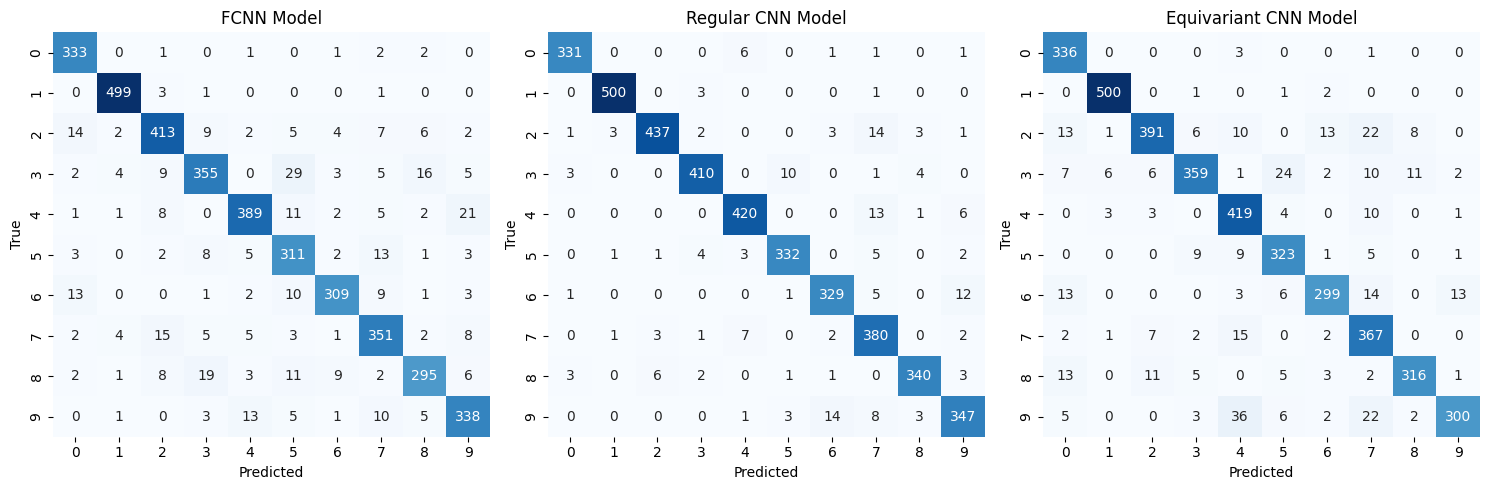

In [39]:
# Create confusion matrices
conf_matrix_a = confusion_matrix(y_test_rot, y_pred_dnn)
conf_matrix_b = confusion_matrix(y_test_rot, y_pred_cnn)
conf_matrix_c = confusion_matrix(y_test_rot, y_pred_eq)

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot confusion matrix for model a
sns.heatmap(conf_matrix_a, annot=True, fmt="d", cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title('FCNN Model')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Plot confusion matrix for model b
sns.heatmap(conf_matrix_b, annot=True, fmt="d", cmap="Blues", ax=axes[1], cbar=False)
axes[1].set_title('Regular CNN Model')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Plot confusion matrix for model c
sns.heatmap(conf_matrix_c, annot=True, fmt="d", cmap="Blues", ax=axes[2], cbar=False)
axes[2].set_title('Equivariant CNN Model')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()